# Peramalan Harga Penutupan Saham BMRI dengan Mempertimbangkan Pengaruh Makroekonomi menggunakan Model Hybrid LSTM-Transformer

* Coding Camp ID: MC008D5Y1552
* Dicoding Username: kurniawanchandrawi
* Email: kurniawanchandrawi@gmail.com

---

Import semua *package* yang dibutuhkan:

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import tensorflow as tf
from sklearn.preprocessing import RobustScaler

# Models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Dense, Dropout, Concatenate, LayerNormalization,
    MultiHeadAttention, Add, Conv1D, Activation, SpatialDropout1D
)

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data Loading

Memanggil data harga penutupan saham BMRI, inflasi, suku bunga, dan kurs dari berkas `.csv` dan `.xlsx`:

In [30]:
saham = pd.read_csv('data/stock_BMRI_IHSG.csv')
inflasi = pd.read_excel('data/inflation.xlsx')
bunga = pd.read_excel('data/interest_rate.xlsx')
kurs = pd.read_csv('data/usd_to_idr.csv')

In [31]:
display(saham.head(), inflasi.head(), bunga.head(), kurs.head())

,Date,BMRI.JK.Adjusted,JKSE.Adjusted
0,2020-01-02,2800.025879,6283.581055
1,2020-01-03,2790.993408,6323.465820
2,2020-01-06,2745.831543,6257.402832
3,2020-01-07,2745.831543,6279.346191
4,2020-01-08,2709.702148,6225.686035


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,NaN
1,Data Inflasi,Data Inflasi,Data Inflasi,Data Inflasi
2,NaN,NaN,NaN,NaN
3,No,Periode,Data Inflasi,NaN
4,1,April 2025,1.95 %,NaN


,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,NaN
1,BI-7Day-RR,BI-7Day-RR,BI-7Day-RR,BI-7Day-RR
2,NaN,NaN,NaN,NaN
3,NO,Tanggal,BI-7Day-RR,NaN
4,1,23 April 2025,5.75 %,NaN


,Date,Price,Open,High,Low,Vol.,Change %
0,05/01/2025,"16,600.0","16,600.0","16,600.0","16,600.0",NaN,0.00%
1,04/30/2025,"16,600.0","16,715.0","16,742.5","16,597.5",NaN,-0.95%
2,04/29/2025,"16,760.0","16,810.0","16,815.0","16,759.5",NaN,-0.56%
3,04/28/2025,"16,855.0","16,835.0","16,867.0","16,830.0",NaN,0.15%
4,04/25/2025,"16,830.0","16,825.0","16,842.5","16,807.5",NaN,-0.24%


Perhatikan bahwa format dari *data frame* masih berantakan, sehingga akan dilakukan pemrosesan awal.

In [32]:
# Pemrosesan data saham
saham['Date'] = pd.to_datetime(saham['Date'])

# Pemrosesan data inflasi
bulan_map = {
    'Januari': 1, 'Februari': 2, 'Maret': 3, 'April': 4,
    'Mei': 5, 'Juni': 6, 'Juli': 7, 'Agustus': 8,
    'September': 9, 'Oktober': 10, 'November': 11, 'Desember': 12
}

def ubah_ke_datetime(bulan_tahun):
    try:
        bulan, tahun = bulan_tahun.split()
        bulan_num = bulan_map[bulan]
        return pd.Timestamp(year=int(tahun), month=bulan_num, day=1)
    except Exception:
        return pd.NaT
    
inflasi = inflasi.iloc[3:, 1:3]
inflasi.columns = inflasi.iloc[0]
inflasi = inflasi[1:]
inflasi.reset_index(drop=True, inplace=True)
inflasi['Periode'] = inflasi['Periode'].apply(ubah_ke_datetime)

# Pemrosesan data suku bunga
def ubah_ke_datetime_lengkap(tanggal_str):
    try:
        bagian = tanggal_str.split()
        tanggal = int(bagian[0])
        bulan = bulan_map[bagian[1]]
        tahun = int(bagian[2])
        return pd.Timestamp(year=tahun, month=bulan, day=tanggal)
    except Exception:
        return pd.NaT

bunga = bunga.iloc[3:, 1:3]
bunga.columns = bunga.iloc[0]
bunga = bunga[1:]
bunga.reset_index(drop=True, inplace=True)
bunga['Tanggal'] = bunga['Tanggal'].apply(ubah_ke_datetime_lengkap)

# Pemrosesan data kurs
kurs = kurs[['Date', 'Price']]
kurs['Date'] = kurs['Date'].astype(str)
kurs['Date'] = pd.to_datetime(kurs['Date'], format='%m/%d/%Y', errors='coerce')

In [33]:
display(saham.head(), inflasi.head(), bunga.head(), kurs.head())

,Date,BMRI.JK.Adjusted,JKSE.Adjusted
0,2020-01-02,2800.025879,6283.581055
1,2020-01-03,2790.993408,6323.465820
2,2020-01-06,2745.831543,6257.402832
3,2020-01-07,2745.831543,6279.346191
4,2020-01-08,2709.702148,6225.686035


3,Periode,Data Inflasi
0,2025-04-01,1.95 %
1,2025-03-01,1.03 %
2,2025-02-01,-0.09 %
3,2025-01-01,0.76 %
4,2024-12-01,1.57 %


3,Tanggal,BI-7Day-RR
0,2025-04-23,5.75 %
1,2025-03-19,5.75 %
2,2025-02-19,5.75 %
3,2025-01-15,5.75 %
4,2024-12-18,6.00 %


,Date,Price
0,2025-05-01,"16,600.0"
1,2025-04-30,"16,600.0"
2,2025-04-29,"16,760.0"
3,2025-04-28,"16,855.0"
4,2025-04-25,"16,830.0"


Penggabungan data:

In [34]:
data = saham.copy()
data = data.merge(inflasi, how='left', left_on='Date', right_on='Periode')
data = data.merge(bunga, how='left', left_on='Date', right_on='Tanggal')
data = data.merge(kurs, how='left', left_on='Date', right_on='Date')

data = data.rename(columns={
    'BMRI.JK.Adjusted': 'BMRI',
    'JKSE.Adjusted': 'IHSG',
    'Data Inflasi': 'Inflasi',
    'BI-7Day-RR': 'Suku Bunga',
    'Price': 'Kurs'
})
data = data.drop(columns=['Periode', 'Tanggal'])

display(data.head())

,Date,BMRI,IHSG,Inflasi,Suku Bunga,Kurs
0,2020-01-02,2800.025879,6283.581055,NaN,NaN,"13,889.0"
1,2020-01-03,2790.993408,6323.465820,NaN,NaN,"13,925.0"
2,2020-01-06,2745.831543,6257.402832,NaN,NaN,"13,940.0"
3,2020-01-07,2745.831543,6279.346191,NaN,NaN,"13,875.0"
4,2020-01-08,2709.702148,6225.686035,NaN,NaN,"13,892.5"


Terdapat *missing value* pada beberapa data karena data inflasi dan suku bunga karena kedua data tersebut tidak diambil dalam jangka waktu harian.

In [35]:
display(data.tail())

,Date,BMRI,IHSG,Inflasi,Suku Bunga,Kurs
1280,2025-04-24,4890.0,6613.478027,NaN,NaN,"16,870.0"
1281,2025-04-25,4900.0,6678.915039,NaN,NaN,"16,830.0"
1282,2025-04-28,4920.0,6722.965820,NaN,NaN,"16,855.0"
1283,2025-04-29,4940.0,6749.075195,NaN,NaN,"16,760.0"
1284,2025-04-30,4890.0,6766.794922,NaN,NaN,"16,600.0"


Data diambil dari 2 Januari 2020 sampai 1 Mei 2025.

In [36]:
print(f"Data sebelum Pre-Processing | Jumlah baris: {data.shape[0]}, Jumlah kolom: {data.shape[1]}")

Data sebelum Pre-Processing | Jumlah baris: 1285, Jumlah kolom: 6


Sebelum dilakukan pemrosesan, terdapat 1.285 baris data dengan 6 kolom.

## Data Cleaning and Preprocessing

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1285 non-null   datetime64[ns]
 1   BMRI        1285 non-null   float64       
 2   IHSG        1285 non-null   float64       
 3   Inflasi     33 non-null     object        
 4   Suku Bunga  64 non-null     object        
 5   Kurs        1285 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 60.4+ KB


Terlihat bahwa data inflasi, suku bunga, dan kurs masih memiliki konvensi non numerik, sehingga akan diperbaiki menjadi numerik dengan cara:
1. menghilangkan `%` pada data inflasi dan suku bunga, dan
2. menghapus `,` sebagai pemisah ribuan pada data kurs.

In [38]:
data['Inflasi'] = data['Inflasi'].str.replace('%', '').str.strip().astype(float) / 100
data['Suku Bunga'] = data['Suku Bunga'].str.replace('%', '').str.strip().astype(float) / 100
data['Kurs'] = data['Kurs'].str.replace(',', '').astype(float)

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285 entries, 0 to 1284
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1285 non-null   datetime64[ns]
 1   BMRI        1285 non-null   float64       
 2   IHSG        1285 non-null   float64       
 3   Inflasi     33 non-null     float64       
 4   Suku Bunga  64 non-null     float64       
 5   Kurs        1285 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 60.4 KB


In [40]:
data.isna().sum()

Date             0
BMRI             0
IHSG             0
Inflasi       1252
Suku Bunga    1221
Kurs             0
dtype: int64

Sebab data inflasi dan suku bunga tersedia pada frekuensi bulanan, nilai harian untuk tanggal di antara pengukuran resmi tidak tersedia sehingga menimbulkan *missing value*. Pengisian menggunakan *forward fill* (serta *backward fill* pada data paling awal) dipilih karena kedua variabel ini biasanya berubah secara bertahap dan relatif stabil dalam jangka pendek, sehingga nilai terakhir yang diketahui dapat dianggap representatif untuk periode berikutnya. Metode ini juga memastikan data lengkap untuk proses pemodelan tanpa menciptakan nilai palsu yang berlebihan, sehingga model dapat mempelajari pola dengan lebih konsisten.

In [41]:
data['Inflasi'] = data['Inflasi'].ffill().bfill()
data['Suku Bunga'] = data['Suku Bunga'].ffill().bfill()

Perhatikan bahwa harga saham tidak tersedia pada hari libur, sehingga data pada hari libur akan dianggap *missing value*, kemudian diisi dengan menggunakan interpolasi berdasarkan waktu. Suatu data runtun waktu yang baik memiliki waktu yang teratur sehingga hal ini perlu dilakukan.

In [42]:
# Konversi kolom Date ke datetime dan set sebagai index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Buat index tanggal lengkap harian
tanggal_lengkap = pd.date_range(start='2020-01-02', end='2025-05-01', freq='D')
data = data.reindex(tanggal_lengkap)

# Interpolasi data kosong berdasarkan waktu
data_interpolated = data.interpolate(method='time')

# Reset index ke kolom Date
data_interpolated = data_interpolated.reset_index().rename(columns={'index': 'Date'})

In [43]:
data_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1947 entries, 0 to 1946
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1947 non-null   datetime64[ns]
 1   BMRI        1947 non-null   float64       
 2   IHSG        1947 non-null   float64       
 3   Inflasi     1947 non-null   float64       
 4   Suku Bunga  1947 non-null   float64       
 5   Kurs        1947 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 91.4 KB


In [44]:
data_interpolated.head()

,Date,BMRI,IHSG,Inflasi,Suku Bunga,Kurs
0,2020-01-02,2800.025879,6283.581055,0.0267,0.05,13889.0
1,2020-01-03,2790.993408,6323.465820,0.0267,0.05,13925.0
2,2020-01-04,2775.939453,6301.444824,0.0267,0.05,13930.0
3,2020-01-05,2760.885498,6279.423828,0.0267,0.05,13935.0
4,2020-01-06,2745.831543,6257.402832,0.0267,0.05,13940.0


Data sudah siap digunakan untuk analisis.

In [45]:
print(f"Data setelah Pre-Processing | Jumlah baris: {data_interpolated.shape[0]}, Jumlah kolom: {data_interpolated.shape[1]}")

Data setelah Pre-Processing | Jumlah baris: 1947, Jumlah kolom: 6


Setelah dilakukan prapemrosesan, terdapat 1.947 baris data dengan 6 kolom.

## Exploratory Data Analysis

### Variable Description

Untuk mendapatkan gambaran lebih jauh terkait data, akan dilihat ringkasan statistik dari data.

In [46]:
data_interpolated.describe()

,Date,BMRI,IHSG,Inflasi,Suku Bunga,Kurs
count,1947,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000
mean,2022-08-31 23:59:59.999999744,3822.255495,6525.555281,0.027635,0.047911,15042.700822
min,2020-01-02 00:00:00,1411.886841,3937.632080,0.013700,0.035000,13572.500000
25%,2021-05-02 12:00:00,2479.502197,6102.360718,0.015500,0.035000,14375.000000
50%,2022-09-01 00:00:00,3649.433838,6762.253906,0.024200,0.047500,14925.000000
75%,2023-12-31 12:00:00,5092.666423,7075.627279,0.033700,0.057500,15615.833333
max,2025-05-01 00:00:00,6769.004883,7905.390137,0.059500,0.062500,16870.000000
std,NaN,1430.435067,770.500040,0.013991,0.010841,760.785209


Data statistik dari periode 2020 hingga 2025 menunjukkan bahwa harga saham BMRI memiliki rata-rata sebesar 3.822 dengan variasi yang cukup tinggi (simpangan baku ±1.430), mencerminkan fluktuasi pasar yang signifikan. IHSG juga menunjukkan tren pertumbuhan dengan rata-rata di 6.525. Selama periode tersebut, inflasi dan suku bunga relatif stabil dengan nilai median masing-masing 2,42% dan 4,75%, sementara nilai tukar rupiah terhadap dolar berkisar antara 13.572 hingga 16.870 dengan rata-rata sekitar 15.043. Data ini mencerminkan kondisi ekonomi Indonesia yang cenderung stabil meskipun terdapat dinamika pasar modal.

### Univariate Analysis

Analisis univariat dilakukan dengan membuat visualisasi *line chart* pada semua data.

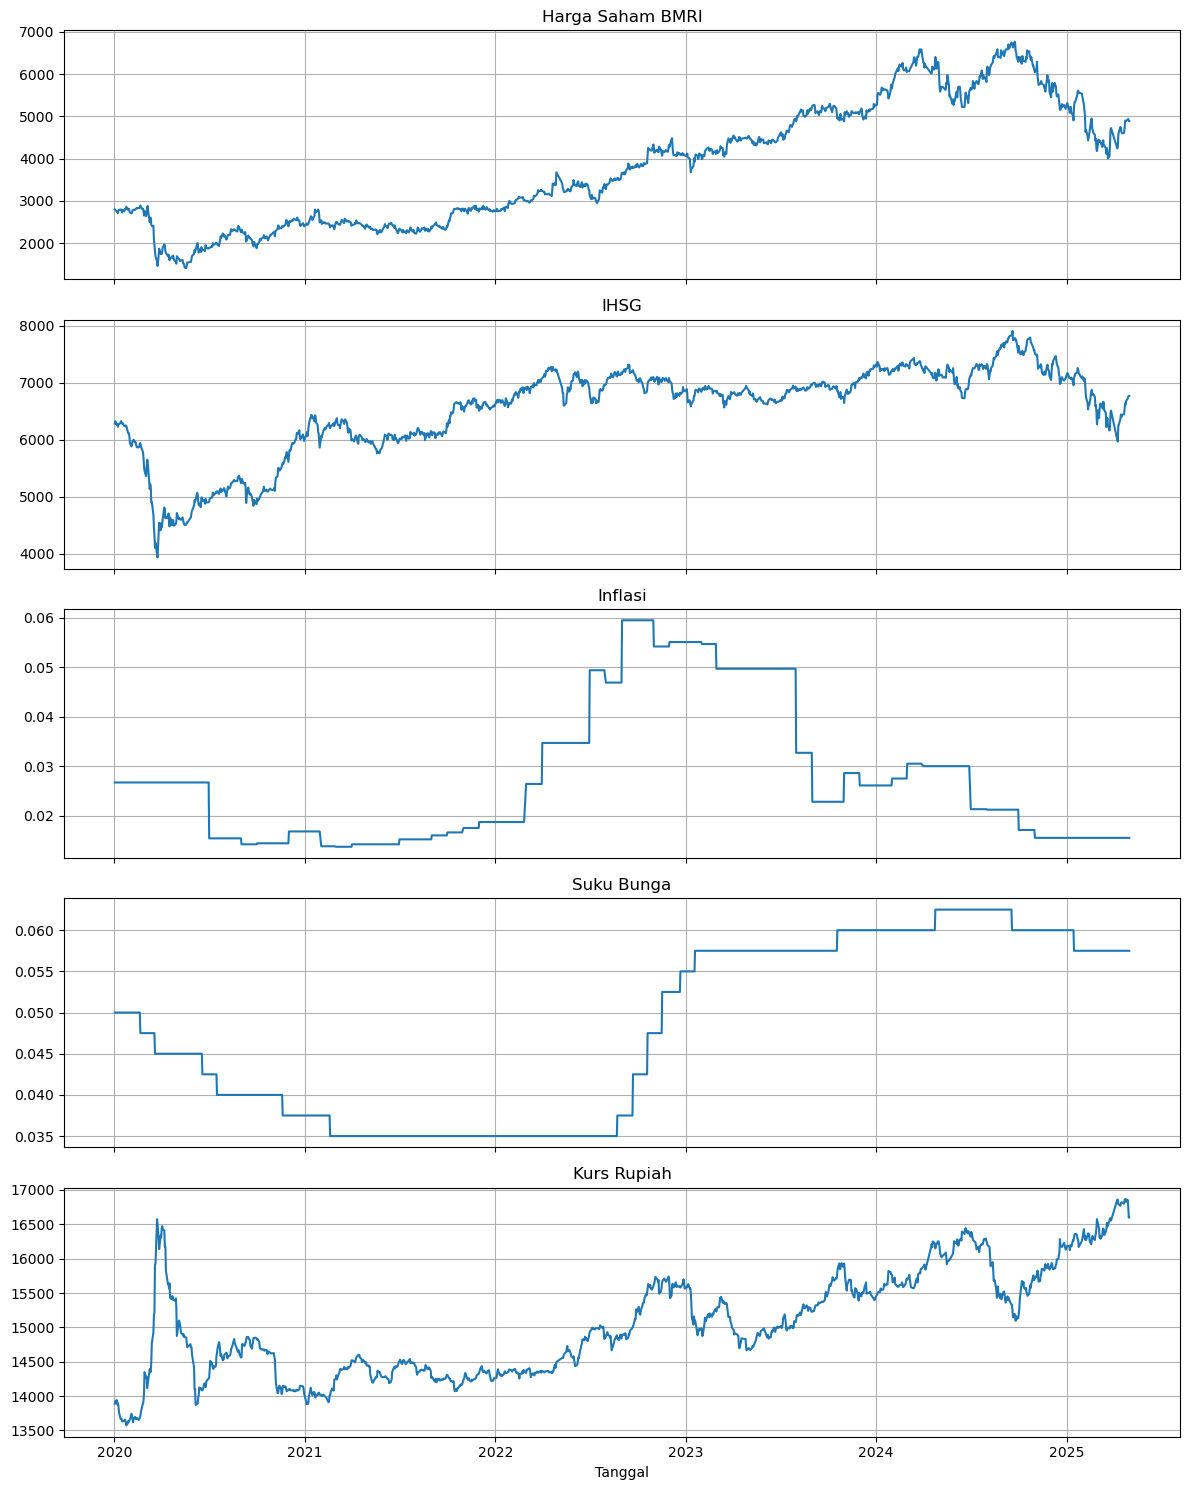

In [47]:
data_interpolated.set_index('Date', inplace=True)

fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

cols = ['BMRI', 'IHSG', 'Inflasi', 'Suku Bunga', 'Kurs']
titles = ['Harga Saham BMRI', 'IHSG', 'Inflasi', 'Suku Bunga', 'Kurs Rupiah']

for ax, col, title in zip(axes, cols, titles):
    ax.plot(data_interpolated.index, data_interpolated[col])
    ax.set_title(title)
    ax.grid(True)

plt.xlabel('Tanggal')
plt.tight_layout()
plt.show()

Grafik ini menunjukkan bahwa harga saham BMRI dan IHSG cenderung naik meski ada fluktuasi, sementara inflasi dan suku bunga meningkat bersamaan pada periode tertentu sebagai respons kebijakan moneter. Kenaikan suku bunga tampaknya digunakan untuk menekan inflasi, yang juga memengaruhi pergerakan kurs rupiah yang relatif fluktuatif sepanjang waktu.

### Multivariate Analysis

Tujuan dari analisis adalah menangkap hubungan antara variabel eksogen (IHSG, inflasi, suku bunga, dan kurs rupiah) terhadap harga saham BMRI. Oleh karena itu, hubungan ini akan diinvestigasi terlebih dahulu melalui matriks korelasi Pearson.

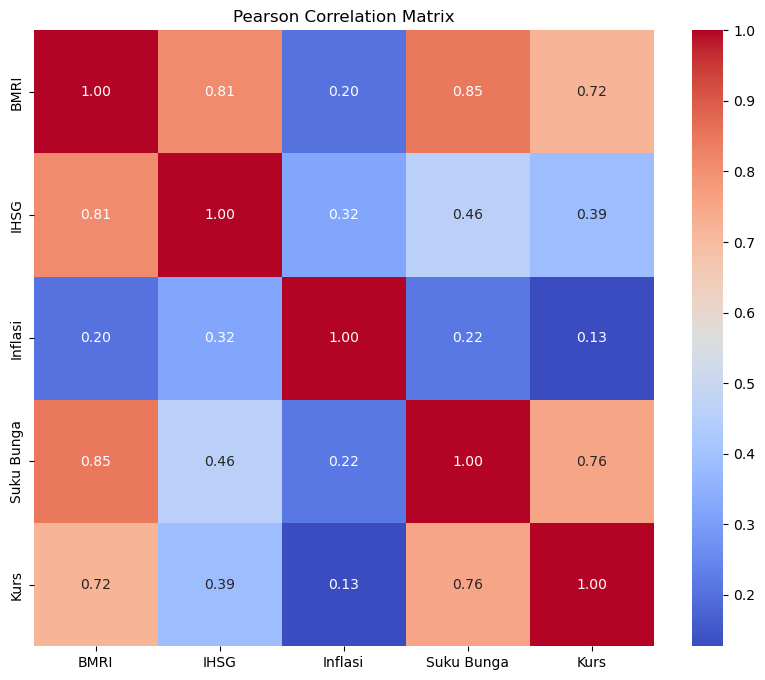

In [48]:
correlation_matrix = data_interpolated.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

Terlihat bahwa harga saham BMRI memiliki korelasi yang cukup tinggi dengan data IHSG, Suku Bunga, dan Kurs. Hal ini menjadi pendukung utama bahwa harga saham BMRI memiliki hubungan terhadap variabel-variabel tersebut.

In [49]:
def correlation_test(series1, series2):
    corr, p_value = pearsonr(series1, series2)
    return corr, p_value

def print_correlation_test(series1, series2, label1, label2):
    corr, p_value = correlation_test(series1, series2)
    print(f'Correlation between {label1} and {label2}: {corr:.4f}, p-value: {p_value:.4f}')

print_correlation_test(data_interpolated['BMRI'], data_interpolated['IHSG'], 'BMRI', 'IHSG')
print_correlation_test(data_interpolated['BMRI'], data_interpolated['Inflasi'], 'BMRI', 'Inflasi')
print_correlation_test(data_interpolated['BMRI'], data_interpolated['Suku Bunga'], 'BMRI', 'Suku Bunga')
print_correlation_test(data_interpolated['BMRI'], data_interpolated['Kurs'], 'BMRI', 'Kurs')

Correlation between BMRI and IHSG: 0.8109, p-value: 0.0000
Correlation between BMRI and Inflasi: 0.2045, p-value: 0.0000
Correlation between BMRI and Suku Bunga: 0.8499, p-value: 0.0000
Correlation between BMRI and Kurs: 0.7203, p-value: 0.0000


Analisis inferensi statistik juga menyebutkan bahwa korelasi antara harga penutupan saham BMRI memiliki korelasi yang signifikan dengan semua variabel eksogen.

## Feature Engineering and Feature Scaling

*Feature engineering* dilakukan dengan menambahkan variabel *lag* untuk variabel eksogen, yaitu IHSG, Inflasi, Suku Bunga, dan Kurs, dengan jumlah *lag* hingga lima periode sebelumnya. Penambahan *lag* ini bertujuan untuk menangkap pengaruh variabel eksogen di masa lalu terhadap harga saham BMRI saat ini. Selanjutnya, *feature scaling* diterapkan menggunakan metode *robust scaling* guna menghasilkan proses penskalaan yang lebih tahan terhadap outlier. Perlu diperhatikan bahwa untuk menjaga efisiensi dan validitas prediksi, variabel eksogen pada waktu ke-$t$ tidak digunakan untuk memprediksi harga saham pada waktu yang sama, karena data eksogen pada waktu tersebut diketahui bersamaan dengan harga saham, sehingga tidak mencerminkan prediksi masa depan.

In [50]:
# Feature Engineering
LAGS = 5
endog_cols = ['BMRI']
exog_cols = ['IHSG', 'Inflasi', 'Suku Bunga', 'Kurs']

for col in exog_cols:
    for lag in range(1, LAGS + 1):
        data_interpolated[f'{col}_lag{lag}'] = data_interpolated[col].shift(lag)

In [51]:
data_interpolated.isna().sum()

BMRI               0
IHSG               0
Inflasi            0
Suku Bunga         0
Kurs               0
IHSG_lag1          1
IHSG_lag2          2
IHSG_lag3          3
IHSG_lag4          4
IHSG_lag5          5
Inflasi_lag1       1
Inflasi_lag2       2
Inflasi_lag3       3
Inflasi_lag4       4
Inflasi_lag5       5
Suku Bunga_lag1    1
Suku Bunga_lag2    2
Suku Bunga_lag3    3
Suku Bunga_lag4    4
Suku Bunga_lag5    5
Kurs_lag1          1
Kurs_lag2          2
Kurs_lag3          3
Kurs_lag4          4
Kurs_lag5          5
dtype: int64

Setelah menambahkan fitur *lag* pada variabel eksogen dengan menggeser data ke belakang sebanyak 1 sampai 5 periode, baris-baris awal data akan mengandung nilai kosong (NaN) karena tidak ada data sebelumnya untuk diisi sebagai *lag*. Oleh karena itu, dilakukan penghapusan baris-baris yang mengandung nilai kosong tersebut menggunakan `dropna()` agar dataset yang digunakan untuk pelatihan dan analisis menjadi lengkap tanpa *missing value*, sehingga model dapat belajar dengan data yang konsisten dan valid.

In [52]:
data_interpolated.dropna(inplace=True)

In [53]:
data_interpolated.drop(columns=exog_cols, inplace=True)
data_interpolated.columns

Index(['BMRI', 'IHSG_lag1', 'IHSG_lag2', 'IHSG_lag3', 'IHSG_lag4', 'IHSG_lag5',
       'Inflasi_lag1', 'Inflasi_lag2', 'Inflasi_lag3', 'Inflasi_lag4',
       'Inflasi_lag5', 'Suku Bunga_lag1', 'Suku Bunga_lag2', 'Suku Bunga_lag3',
       'Suku Bunga_lag4', 'Suku Bunga_lag5', 'Kurs_lag1', 'Kurs_lag2',
       'Kurs_lag3', 'Kurs_lag4', 'Kurs_lag5'],
      dtype='object')

In [54]:
# Feature Scaling
cols_to_scale = endog_cols + [f'{col}_lag{lag}' for col in exog_cols for lag in range(1, LAGS + 1)]
scaler = RobustScaler()
scaled_data = scaler.fit_transform(data_interpolated[cols_to_scale])
scaled_df = data_interpolated[cols_to_scale].copy()
scaled_df.loc[:, :] = scaled_data

In [55]:
# Menampilkan informasi data
print(f"Data setelah Feature Engineering | Jumlah baris: {scaled_df.shape[0]}, Jumlah kolom: {scaled_df.shape[1]}")

Data setelah Feature Engineering | Jumlah baris: 1942, Jumlah kolom: 21


## Data Splitting and Sequencing

In [41]:
def create_sequences(data, seq_len, endog_cols, exog_cols, lags):
    """
    Membuat data sequence untuk input model time series.

    Args:
        data (pd.DataFrame): Dataframe berisi fitur.
        seq_len (int): Panjang sequence input.
        endog_cols (list): List nama kolom endogen (target).
        exog_cols (list): List nama kolom eksogen (fitur tambahan).
        lags (int): Jumlah lag fitur eksogen.

    Returns:
        tuple: (X_endog, X_exog, y) sebagai numpy array.
    """
    X_endog, X_exog, y = [], [], []
    exog_lag_cols = [f'{col}_lag{lag}' for col in exog_cols for lag in range(1, lags+1)]
    for i in range(seq_len, len(data)):
        X_endog.append(data[endog_cols].iloc[i-seq_len:i].values)
        X_exog.append(data[exog_lag_cols].iloc[i-seq_len:i].values)
        y.append(data[endog_cols].iloc[i].values)
    return np.array(X_endog), np.array(X_exog), np.array(y)

Dalam pemodelan deep learning untuk data runtun waktu, sequences dibutuhkan karena model seperti LSTM atau GRU mempelajari pola berdasarkan urutan atau konteks waktu sebelumnya. Tidak seperti data tabular biasa, data runtun waktu memiliki ketergantungan temporal, sehingga untuk memprediksi nilai saat ini atau masa depan, model harus diberi informasi tentang nilai-nilai sebelumnya dalam bentuk urutan (sequence). Fungsi `create_sequences` tersebut membentuk input dengan panjang urutan tertentu (misalnya 30 hari sebelumnya) agar model dapat memahami dinamika waktu dan hubungan antar fitur endogen dan eksogen secara historis.

In [42]:
SEQ_LEN = 28
X_endog, X_exog, y = create_sequences(scaled_df, SEQ_LEN, endog_cols, exog_cols, LAGS)

split_idx = int(len(X_endog) * 0.8) # 80% untuk training
X_endog_train, X_endog_test = X_endog[:split_idx], X_endog[split_idx:]
X_exog_train, X_exog_test = X_exog[:split_idx], X_exog[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

## Modeling

Tiga model akan diaplikasikan pada data, yaitu LSTM dengan *multi input*, *hybrid* LSTM-Transformer, dan *hybrind* LSTM-Transformer-TCN. Dalam proses pembuatan model, akan dibentuk beberapa fungsi bantu, yaitu pembangunan dan pelatihan model, *inverse transform*, evaluasi model, *multi-step forecast*, dan visualisasi. 

In [45]:
def inverse_transform(scaler, y_scaled, X_exog_sample, exog_cols, lags):
    """
    Melakukan inverse transform hasil scaling untuk output dan eksogen.

    Args:
        scaler (RobustScaler): Scaler yang sudah fit.
        y_scaled (np.array): Data target hasil prediksi atau asli, sudah diskalakan.
        X_exog_sample (np.array): Sample data eksogen terakhir sesuai urutan lag.
        exog_cols (list): List nama fitur eksogen.
        lags (int): Jumlah lag fitur eksogen.

    Returns:
        np.array: Data asli hasil inverse transform.
    """
    exog_lag_cols = [f'{col}_lag{lag}' for col in exog_cols for lag in range(1, lags+1)]
    dummy = np.hstack([y_scaled, X_exog_sample[:, -1, :]])
    inv = scaler.inverse_transform(dummy)
    return inv[:, 0]

Pembangunan model LSTM-Multi Input, LSTM-Transformer, dan LSTM-Transformer-TCN:

In [44]:
def build_lstm_multi_input(seq_len, n_endog, n_exog, lstm_units=64, dropout_rate=0.2):
    """
    Bangun model LSTM dengan dua input (endogen dan eksogen).

    Args:
        seq_len (int): Panjang sequence input (timesteps).
        n_endog (int): Jumlah fitur endogen (target).
        n_exog (int): Jumlah fitur eksogen (fitur tambahan).
        lstm_units (int, optional): Jumlah neuron di layer LSTM. Default 64.
        dropout_rate (float, optional): Dropout rate untuk regularisasi. Default 0.2.

    Returns:
        tf.keras.Model: Model siap training.

    Raises:
        ValueError: Jika ada parameter input tidak valid (misal negatif atau nol).
        TypeError: Jika tipe parameter salah.
    """
    # Validasi input
    for name, val in zip(
        ['seq_len', 'n_endog', 'n_exog', 'lstm_units'], 
        [seq_len, n_endog, n_exog, lstm_units]
    ):
        if not isinstance(val, int) or val <= 0:
            raise ValueError(f"{name} harus integer positif, dapat: {val}")
    if not (0 <= dropout_rate <= 1):
        raise ValueError(f"dropout_rate harus di antara 0 dan 1, dapat: {dropout_rate}")

    input_endog = Input(shape=(seq_len, n_endog))
    input_exog = Input(shape=(seq_len, n_exog))
    x = Concatenate()([input_endog, input_exog])
    x = LSTM(lstm_units)(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(n_endog)(x)
    model = Model(inputs=[input_endog, input_exog], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def build_lstm_transformer(
    seq_len, n_endog, n_exog, lstm_units=64, transformer_heads=4,
    transformer_dim=32, dropout_rate=0.2
):
    """
    Model LSTM-Transformer untuk time series forecasting.

    Args:
        seq_len (int): Panjang sequence input (timesteps).
        n_endog (int): Jumlah fitur endogen (target).
        n_exog (int): Jumlah fitur eksogen (fitur tambahan).
        lstm_units (int, optional): Jumlah neuron di layer LSTM. Default 64.
        transformer_heads (int, optional): Jumlah head di MultiHeadAttention. Default 4.
        transformer_dim (int, optional): Dimensi key/query pada MultiHeadAttention. Default 32.
        dropout_rate (float, optional): Dropout rate untuk regularisasi. Default 0.2.

    Returns:
        tf.keras.Model: Model siap training.

    Raises:
        ValueError: Jika parameter input tidak valid.
    """
    # Validasi parameter
    for name, val in zip(
        ['seq_len', 'n_endog', 'n_exog', 'lstm_units', 'transformer_heads', 'transformer_dim'], 
        [seq_len, n_endog, n_exog, lstm_units, transformer_heads, transformer_dim]
    ):
        if not isinstance(val, int) or val <= 0:
            raise ValueError(f"{name} harus integer positif, dapat: {val}")
    if not (0 <= dropout_rate <= 1):
        raise ValueError(f"dropout_rate harus di antara 0 dan 1, dapat: {dropout_rate}")

    input_endog = Input(shape=(seq_len, n_endog))
    input_exog = Input(shape=(seq_len, n_exog))

    x_endog = LSTM(lstm_units)(input_endog)
    x_endog = Dropout(dropout_rate)(x_endog)

    exog_norm1 = LayerNormalization(epsilon=1e-6)(input_exog)
    attn_output = MultiHeadAttention(num_heads=transformer_heads, key_dim=transformer_dim)(exog_norm1, exog_norm1)
    attn_output = Dropout(dropout_rate)(attn_output)
    exog_res1 = Add()([input_exog, attn_output])
    exog_norm2 = LayerNormalization(epsilon=1e-6)(exog_res1)

    ff = Dense(transformer_dim * 4, activation='relu')(exog_norm2)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(n_exog)(ff)
    exog_out = Add()([exog_res1, ff])

    concat = Concatenate()([x_endog, tf.keras.layers.GlobalAveragePooling1D()(exog_out)])

    output = Dense(n_endog)(concat)

    model = Model(inputs=[input_endog, input_exog], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def tcn_block(x, filters, kernel_size=3, dilation_rate=1, dropout=0.2):
    """
    Satu blok Temporal Convolutional Network (TCN) dengan residual connection.

    Args:
        x (tf.Tensor): Input layer.
        filters (int): Jumlah filter Conv1D.
        kernel_size (int, optional): Ukuran kernel Conv1D. Default 3.
        dilation_rate (int, optional): Dilation rate Conv1D. Default 1.
        dropout (float, optional): Dropout rate. Default 0.2.

    Returns:
        tf.Tensor: Output layer setelah TCN block.

    Raises:
        ValueError: Jika parameter tidak valid.
    """
    if not isinstance(filters, int) or filters <= 0:
        raise ValueError(f"filters harus integer positif, dapat: {filters}")
    if not isinstance(kernel_size, int) or kernel_size <= 0:
        raise ValueError(f"kernel_size harus integer positif, dapat: {kernel_size}")
    if not isinstance(dilation_rate, int) or dilation_rate <= 0:
        raise ValueError(f"dilation_rate harus integer positif, dapat: {dilation_rate}")
    if not (0 <= dropout <= 1):
        raise ValueError(f"dropout harus di antara 0 dan 1, dapat: {dropout}")

    conv = Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    conv = SpatialDropout1D(dropout)(conv)
    conv = Activation('relu')(conv)
    res = Conv1D(filters, 1, padding='same')(x)
    out = Add()([res, conv])
    out = Activation('relu')(out)
    return out


def build_lstm_transformer_tcn(
    seq_len, n_endog, n_exog, lstm_units=32, filters=32,
    kernel_size=3, dilation_rates=None, transformer_heads=4,
    transformer_dim=32, dropout_rate=0.2
):
    """
    Model LSTM-Transformer-TCN untuk time series forecasting.

    Args:
        seq_len (int): Panjang sequence input (timesteps).
        n_endog (int): Jumlah fitur endogen.
        n_exog (int): Jumlah fitur eksogen.
        lstm_units (int, optional): Jumlah neuron LSTM. Default 32.
        filters (int, optional): Jumlah filter Conv1D di TCN. Default 32.
        kernel_size (int, optional): Ukuran kernel Conv1D. Default 3.
        dilation_rates (list or None, optional): Daftar dilation rate untuk blok TCN. Default [1, 2, 4, 8].
        transformer_heads (int, optional): Jumlah head MultiHeadAttention. Default 4.
        transformer_dim (int, optional): Dimensi key/query Transformer. Default 32.
        dropout_rate (float, optional): Dropout rate regularisasi. Default 0.2.

    Returns:
        tf.keras.Model: Model siap training.

    Raises:
        ValueError: Jika parameter tidak valid.
    """
    if dilation_rates is None:
        dilation_rates = [1, 2, 4, 8]

    # Validasi parameter
    int_params = {
        'seq_len': seq_len,
        'n_endog': n_endog,
        'n_exog': n_exog,
        'lstm_units': lstm_units,
        'filters': filters,
        'kernel_size': kernel_size,
        'transformer_heads': transformer_heads,
        'transformer_dim': transformer_dim,
    }
    for name, val in int_params.items():
        if not isinstance(val, int) or val <= 0:
            raise ValueError(f"{name} harus integer positif, dapat: {val}")

    if not (0 <= dropout_rate <= 1):
        raise ValueError(f"dropout_rate harus di antara 0 dan 1, dapat: {dropout_rate}")

    if not isinstance(dilation_rates, (list, tuple)) or not all(isinstance(d, int) and d > 0 for d in dilation_rates):
        raise ValueError("dilation_rates harus list/tuple berisi integer positif")

    input_endog = Input(shape=(seq_len, n_endog))
    input_exog = Input(shape=(seq_len, n_exog))

    # Transformer block untuk eksogen
    exog_norm1 = LayerNormalization(epsilon=1e-6)(input_exog)
    attn = MultiHeadAttention(num_heads=transformer_heads, key_dim=transformer_dim)(exog_norm1, exog_norm1)
    attn = Dropout(dropout_rate)(attn)
    exog_res1 = Add()([input_exog, attn])
    exog_norm2 = LayerNormalization(epsilon=1e-6)(exog_res1)

    ff = Dense(transformer_dim * 4, activation='relu')(exog_norm2)
    ff = Dropout(dropout_rate)(ff)
    ff = Dense(n_exog)(ff)
    exog_out = Add()([exog_res1, ff])

    # TCN blocks untuk endogen
    x = input_endog
    for d in dilation_rates:
        x = tcn_block(x, filters=filters, kernel_size=kernel_size, dilation_rate=d, dropout=dropout_rate)
    x = Dropout(dropout_rate)(x)

    # Gabungkan fitur TCN dan Transformer eksogen
    concat = Concatenate()([x, exog_out])

    # LSTM setelah concat
    lstm_out = LSTM(lstm_units)(concat)
    lstm_out = Dropout(dropout_rate)(lstm_out)

    output = Dense(n_endog)(lstm_out)

    model = Model(inputs=[input_endog, input_exog], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model

Pembangunan fungsi pelatihan:

In [48]:
def train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs=100,
    batch_size=32,
    early_stopping_patience=15,
    reduce_lr_factor=0.5,
    reduce_lr_patience=5,
    callbacks=None,
    verbose=1
):
    """
    Melatih model TensorFlow Keras dengan callback EarlyStopping dan ReduceLROnPlateau.

    Args:
        model (tf.keras.Model): Model yang akan dilatih.
        X_train (array-like): Data input training.
        y_train (array-like): Target output training.
        X_val (array-like): Data input validasi.
        y_val (array-like): Target output validasi.
        epochs (int, optional): Jumlah epoch pelatihan. Default 100.
        batch_size (int, optional): Ukuran batch untuk pelatihan. Default 32.
        early_stopping_patience (int, optional): Jumlah epoch tanpa peningkatan sebelum menghentikan pelatihan lebih awal. Default 15.
        reduce_lr_factor (float, optional): Faktor pengurangan learning rate saat tidak ada peningkatan. Default 0.5.
        reduce_lr_patience (int, optional): Jumlah epoch tanpa peningkatan sebelum learning rate dikurangi. Default 5.
        callbacks (list, optional): Daftar callback tambahan yang ingin digunakan. Default None.
        verbose (int, optional): Verbosity mode pelatihan (0 = silent, 1 = progress bar, 2 = satu baris per epoch). Default 1.

    Returns:
        tf.keras.callbacks.History: Objek history yang berisi riwayat pelatihan.
    """
    # Setup default callbacks jika tidak ada input tambahan
    default_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=early_stopping_patience, restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            factor=reduce_lr_factor, patience=reduce_lr_patience
        ),
    ]

    if callbacks is not None:
        default_callbacks.extend(callbacks)

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=default_callbacks,
        verbose=verbose,
    )
    return history

Pembangunan fungsi evaluasi dan peramalan:

In [ ]:
def evaluate_forecast(y_true, y_pred):
    """
    Menghitung beberapa metrik evaluasi untuk hasil prediksi terhadap nilai sebenarnya.

    Metrik yang dihitung:
    - MSE (Mean Squared Error)
    - RMSE (Root Mean Squared Error)
    - MAE (Mean Absolute Error)
    - MAPE (Mean Absolute Percentage Error)
    - R2 (Coefficient of Determination)

    Args:
        y_true (array-like): Array atau list berisi nilai asli.
        y_pred (array-like): Array atau list berisi nilai prediksi.

    Returns:
        dict: Dictionary yang berisi nilai metrik evaluasi dengan keys
              'MSE', 'RMSE', 'MAE', 'MAPE', dan 'R2'.

    Raises:
        ValueError: Jika panjang y_true dan y_pred tidak sama.
        TypeError: Jika input bukan array-like numerik.
    """
    # Validasi input
    if len(y_true) != len(y_pred):
        raise ValueError("Panjang y_true dan y_pred harus sama.")
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    if y_true.ndim != 1 or y_pred.ndim != 1:
        raise ValueError("Input harus berupa array 1 dimensi.")

    # Hitung metrik
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    # Hitung MAPE dengan penanganan pembagian nol
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.abs((y_true - y_pred) / y_true)
        mape = mape[~np.isinf(mape)]  # buang inf akibat pembagian nol
        mape = mape[~np.isnan(mape)]  # buang NaN jika ada
        mape = np.mean(mape) * 100 if len(mape) > 0 else np.nan

    r2 = r2_score(y_true, y_pred)

    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

def multi_step_forecast(model, X_endog_last, X_exog_last, steps, lags):
    """
    Forecast multi-step ke depan secara iteratif,
    menggunakan prediksi sebelumnya sebagai input berikutnya,
    dan menggunakan nilai eksogen terakhir untuk eksogen masa depan.

    Args:
        model : trained keras model
        X_endog_last : np.array shape (seq_len, n_endog), sequence terakhir endogen
        X_exog_last : np.array shape (seq_len, n_exog), sequence terakhir eksogen
        steps : int, jumlah langkah ke depan yang di-forecast
        lags : int, jumlah lag eksogen

    Returns:
        np.array shape (steps, n_endog), hasil forecast
    """
    preds = []
    endog_seq = X_endog_last.copy()
    exog_seq = X_exog_last.copy()

    for _ in range(steps):
        pred = model.predict([endog_seq[np.newaxis, :, :], exog_seq[np.newaxis, :, :]])[0]
        preds.append(pred)

        # Geser sequence endogen dan tambahkan prediksi terbaru
        endog_seq = np.vstack([endog_seq[1:], pred[np.newaxis, :]])

        # Geser sequence eksogen, isi dengan nilai terakhir (asumsi konstan)
        exog_seq = np.vstack([exog_seq[1:], exog_seq[-1:]])

    return np.array(preds)

### Model Training

Peramalan dilakukan pada 30 hari ke depan.

In [59]:
models_info = {
    "LSTM Multi Input": build_lstm_multi_input(SEQ_LEN, len(endog_cols), X_exog.shape[2]),
    "LSTM-Transformer": build_lstm_transformer(
        seq_len=SEQ_LEN,
        n_endog=len(endog_cols),
        n_exog=X_exog.shape[2],
        lstm_units=256,
        transformer_heads=8,
        transformer_dim=128,
        dropout_rate=0.2
    ),
    "LSTM-Transformer-TCN": build_lstm_transformer_tcn(
        seq_len=SEQ_LEN,
        n_endog=len(endog_cols),
        n_exog=X_exog.shape[2],
        lstm_units=256,
        filters=32,
        kernel_size=3,
        dilation_rates=[1, 2, 4, 8],
        transformer_heads=8,
        transformer_dim=128,
        dropout_rate=0.2
    )
}

forecast_steps = 30 # Jumlah langkah ke depan untuk forecast

# Untuk menyimpan hasil semua model
all_results = {}
loss_histories = {}
metrics_list = []

for name, model in models_info.items():
    print(f"\n=== Training dan Evaluasi Model: {name} ===")
    model.summary()

    # Train model & simpan history
    history = train_model(model, [X_endog_train, X_exog_train], y_train, [X_endog_test, X_exog_test], y_test)
    loss_histories[name] = history

    # Prediksi train & test
    y_train_pred = model.predict([X_endog_train, X_exog_train])
    y_test_pred = model.predict([X_endog_test, X_exog_test])

    # Inverse transform
    y_train_orig = inverse_transform(scaler, y_train, X_exog_train, exog_cols, LAGS)
    y_train_pred_orig = inverse_transform(scaler, y_train_pred, X_exog_train, exog_cols, LAGS)
    y_test_orig = inverse_transform(scaler, y_test, X_exog_test, exog_cols, LAGS)
    y_test_pred_orig = inverse_transform(scaler, y_test_pred, X_exog_test, exog_cols, LAGS)

    # Forecast 30 langkah
    last_endog_seq = X_endog_test[-1]
    last_exog_seq = X_exog_test[-1]
    forecast_scaled = multi_step_forecast(model, last_endog_seq, last_exog_seq, forecast_steps, LAGS)

    last_exog = last_exog_seq[-1, :]
    forecast_exog_full = np.tile(last_exog, (forecast_steps, 1))
    forecast_full = scaler.inverse_transform(np.hstack([forecast_scaled, forecast_exog_full]))[:, 0]

    # Simpan hasil
    all_results[name] = {
        "y_train_orig": y_train_orig.flatten(),
        "y_train_pred": y_train_pred_orig.flatten(),
        "y_test_orig": y_test_orig.flatten(),
        "y_test_pred": y_test_pred_orig.flatten(),
        "forecast": forecast_full.flatten()
    }

    # Evaluasi metrik
    metrics = evaluate_forecast(y_test_orig.flatten(), y_test_pred_orig.flatten())
    metrics["Model"] = name
    metrics_list.append(metrics)


=== Training dan Evaluasi Model: LSTM Multi Input ===
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 28, 1)]              0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 28, 20)]             0         []                            
                                                                                                  
 concatenate_9 (Concatenate  (None, 28, 21)               0         ['input_19[0][0]',            
 )                                                                   'input_20[0][0]']            
                                                                                                  
 lstm_9 (LSTM)               (None, 6

Mengecek konvergensi dengan plot *loss history*:

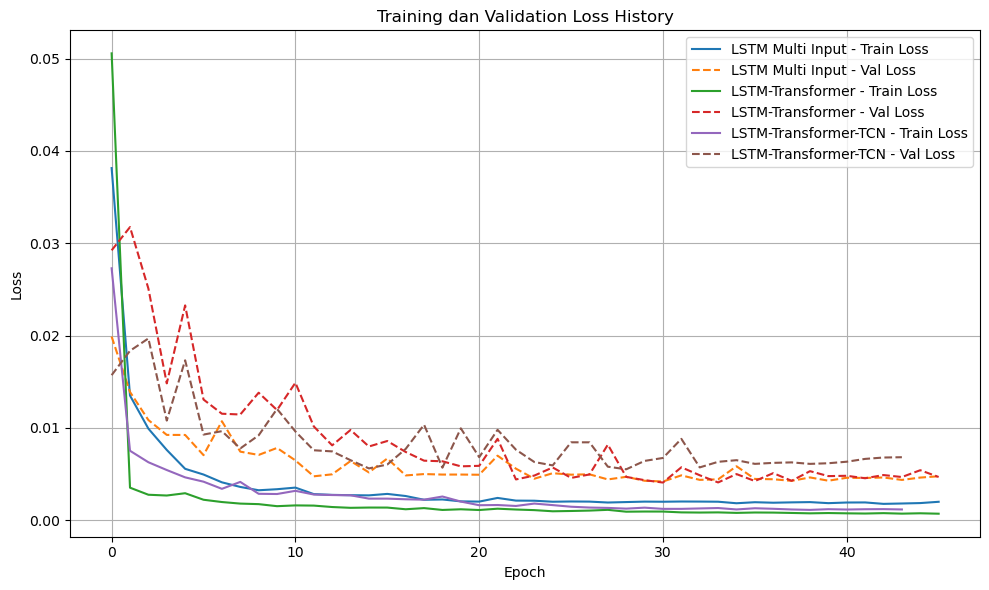

In [63]:
# Plot loss history semua model
plt.figure(figsize=(10, 6))
for name, history in loss_histories.items():
    plt.plot(history.history['loss'], label=f'{name} - Train Loss')
    plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} - Val Loss')

plt.title("Training dan Validation Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Semua model sudah mencapai konvergensi.

Melakukan prediksi:

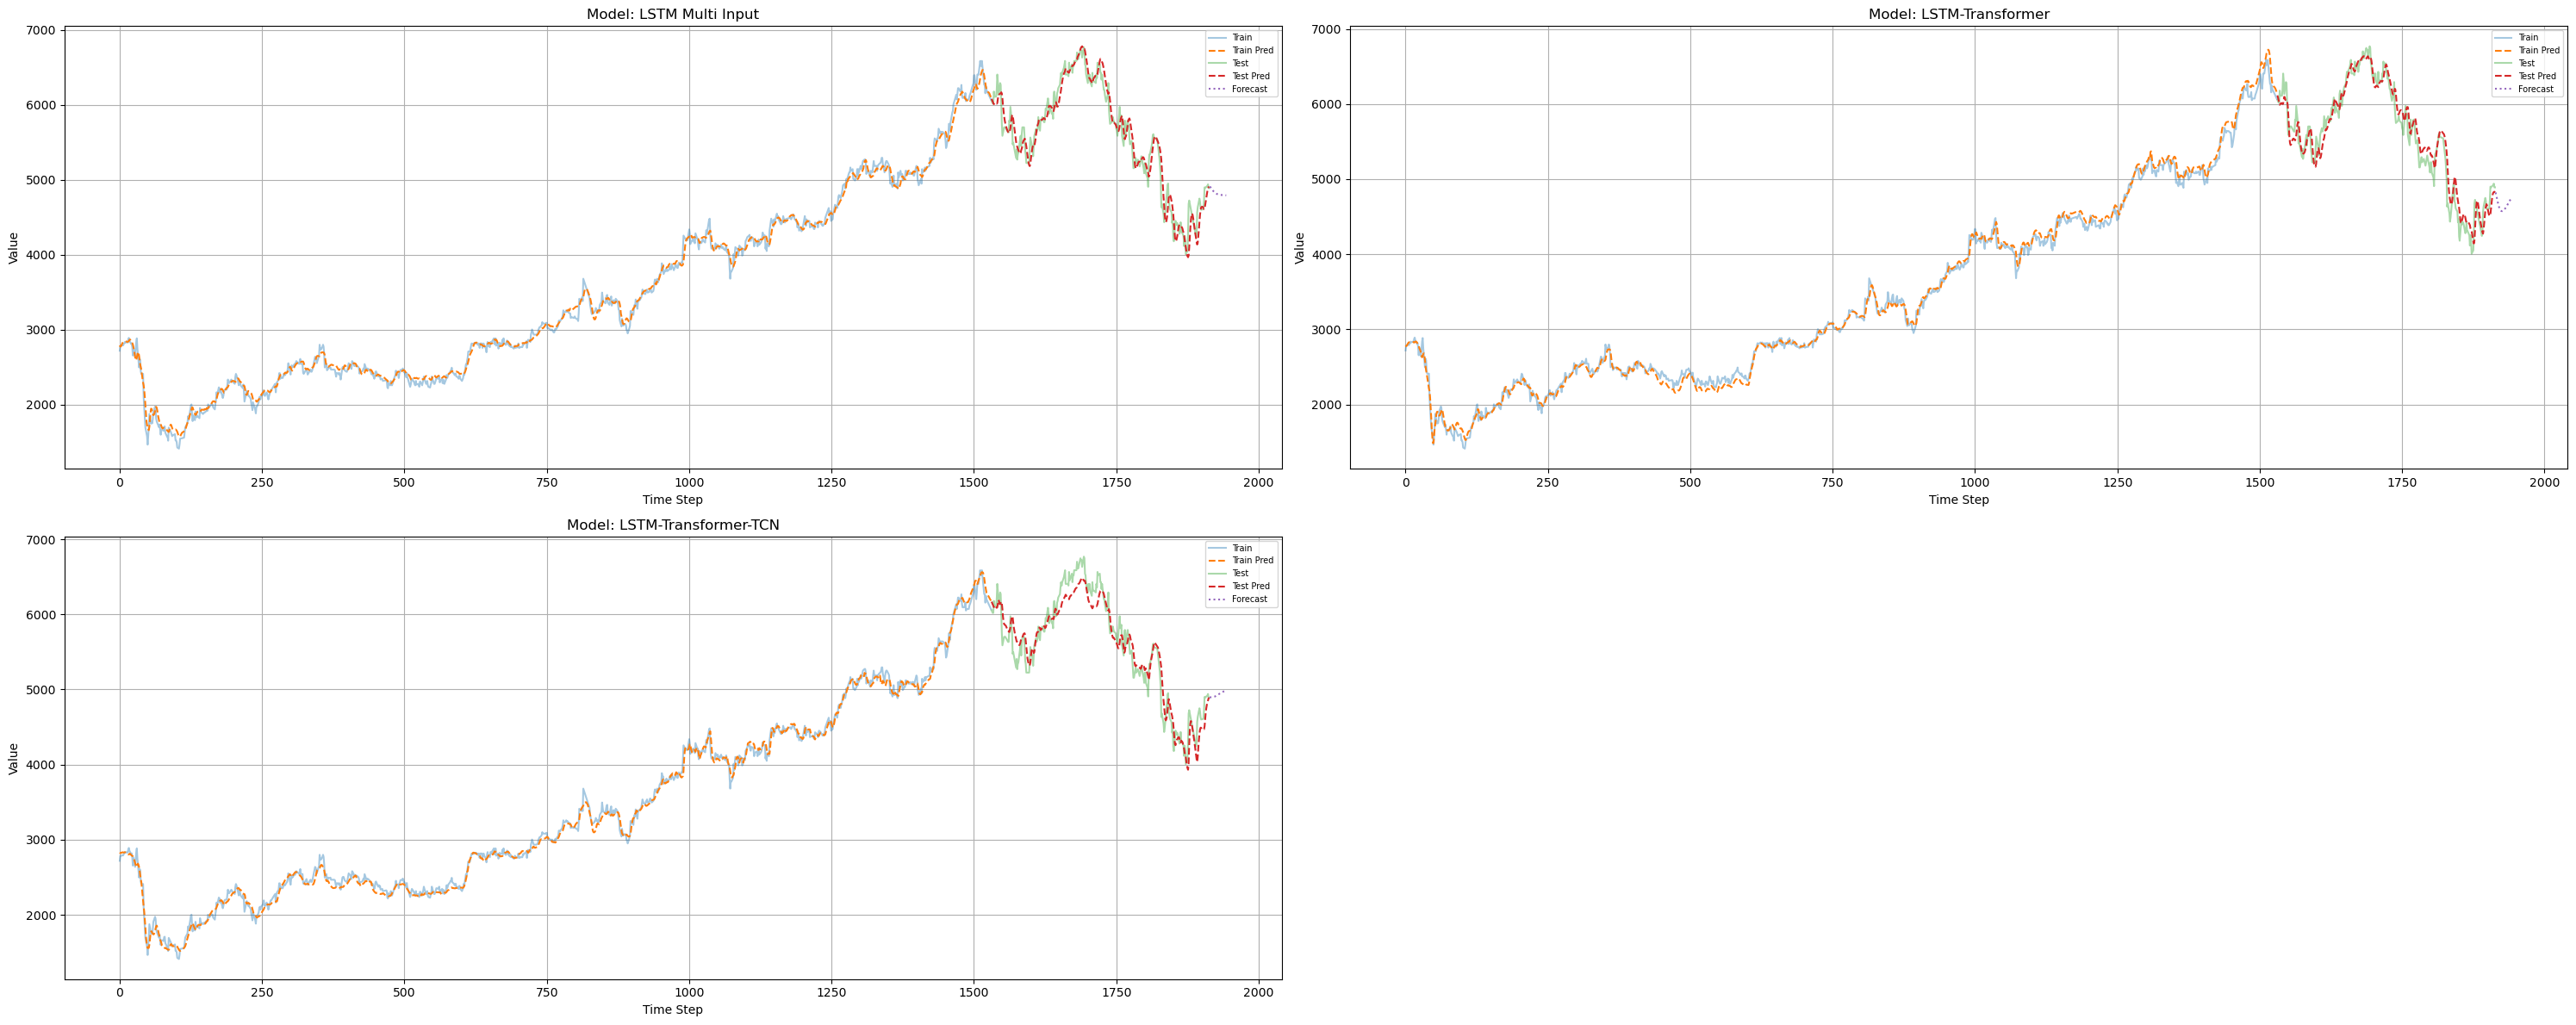

In [64]:
num_models = len(all_results)
cols = 2
rows = math.ceil(num_models / cols)

fig, axs = plt.subplots(rows, cols, figsize=(cols * 15, rows * 6), squeeze=False)
axs = axs.flatten()

for i, (name, result) in enumerate(all_results.items()):
    ax = axs[i]
    total_len = len(result["y_train_orig"]) + len(result["y_test_orig"])

    ax.plot(range(len(result["y_train_orig"])), result["y_train_orig"], label="Train", alpha=0.4)
    ax.plot(range(len(result["y_train_orig"])), result["y_train_pred"], linestyle="--", label="Train Pred")

    ax.plot(range(len(result["y_train_orig"]), total_len), result["y_test_orig"], label="Test", alpha=0.4)
    ax.plot(range(len(result["y_train_orig"]), total_len), result["y_test_pred"], linestyle="--", label="Test Pred")

    forecast_range = range(total_len, total_len + forecast_steps)
    ax.plot(forecast_range, result["forecast"], linestyle=":", label="Forecast")

    ax.set_title(f"Model: {name}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.grid(True)
    ax.legend(fontsize=7)

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

Terlihat bahwa ketiga model dapat menangkap pola dengan sangat baik pada data latih dan data uji. Meskipun demikian, peramalan 30 hari ke depan menunjukkan hasil yang berbeda-beda. Model LSTM menunjukkan peramalan kenaikan, LSTM-Transformer menunjukkan adanya penurunan diikuti oleh kenaikan, sedangkan model LSTM-Transformer-TCN menunjukkan adanya kenaikan harga saham. Untuk menentukan model yang akan dijadikan sebagai acuan, akan dibandingkan menggunakan metrik evaluasi berikut.

In [65]:
df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics[['Model', 'MSE', 'RMSE', 'MAE', 'MAPE', 'R2']].sort_values(by='RMSE')
print("\n=== Evaluasi Model Berdasarkan Test Set ===")
display(df_metrics)


=== Evaluasi Model Berdasarkan Test Set ===


,Model,MSE,RMSE,MAE,MAPE,R2
1,LSTM-Transformer,27850.844226,166.885722,133.110459,2.507180,0.943094
0,LSTM Multi Input,28631.024189,169.207045,125.330830,2.341398,0.941500
2,LSTM-Transformer-TCN,37688.358049,194.134897,154.632905,2.805761,0.922994


Terlihat bahwa model LSTM-Transformer merupakan model yang paling baik karena memiliki MSE dan RMSE yang paling rendah serta $R^2$ yang paling tinggi.

## Conclusion

Berdasarkan hasil forecast dari model LSTM-Transformer, terlihat adanya potensi *rebound* setelah tren penurunan, yang ditunjukkan oleh kenaikan nilai pada prediksi ke depan. Hal ini dapat menjadi sinyal awal untuk menahan (*hold*) atau mulai membeli saham secara bertahap, terutama bagi investor yang mencari peluang saat harga rendah sebelum naik kembali. Namun, karena tren sebelumnya adalah penurunan tajam, disarankan untuk tetap berhati-hati dan mempertimbangkan indikator lain sebelum mengambil keputusan besar, seperti volume perdagangan, sentimen pasar, atau konfirmasi dari model lain.